# X-band Downlink Analysis

**Author:** Your Name  
**Affiliation:** Your organisation / project  
**Date:** YYYY-MM-DD  
**Version:** 1.0  

---

### Description
This notebook computes the power flux-density (PFD) at the Earth's surface for a CubeSat X-band downlink and compares it against the ITU Radio Regulations Article 21 mask (8025–8400 MHz).  

It includes:
- Radio/antenna profiles (e.g. EnduroSat, SAIT) loaded from YAML.
- Computation of EIRP, PFD, and compliance margins vs elevation.
- Plots of PFD vs ITU mask and compliance margins.

### References
- ITU Radio Regulations, Article 21 (PFD limits)
- Antenna datasheets (e.g., Printech PCLL 4×4 patch)
- Mission link budget assumptions

---

# Multi‑Radio X‑band Link Margin & PFD vs Elevation

This notebook reads a **mission parameters CSV** with one or more **radio columns** (e.g., `Endurosat`, `SAIT`) and computes, for each radio:

- Slant range, FSPL, EIRP, C/N₀, Eb/N₀, **Link Margin**, and **PFD (dBW/m²)**
- Elevations **0, 5, 10, …, 90°**
- Altitudes **500 km** and **600 km**

It then:
- Saves a **parameters printout** copy of your CSV,
- Writes **combined** & **per‑radio** results CSVs, and
- Produces **Link Margin vs Elevation** and **PFD vs Elevation** plots for each radio.

---

## How to use

1. Put your CSV (e.g., `x_down_info_2.csv`) next to this notebook, or update `CSV_CANDIDATES` below.
2. Run the **Setup** cell, then the **Helpers** cell, then the **Run** cell.
3. Results are saved to `OUTPUT_DIR` and also shown inline.

**Tip:** Add new radios by adding more columns to the CSV (e.g., `MyNewRadio`). The notebook auto-detects any radio columns that have at least three of the core variables present.

## Expected CSV columns

- One identifier column named **`python_variable`** (case-insensitive match).
- Optional metadata columns like `Parameter`, `Units`, etc.
- One or more **radio columns** (e.g., `Endurosat`, `SAIT`). Helper columns like `Endurosat (db)` are ignored by the code.

**Required variables (by `python_variable`):**
- `selected_carrier_frequency` (GHz)  
- `tx_power` (W)  
- `peak_boresight_antenna_gain` (dBi)  
- `g_t` (dB/K)  
- `data_rate_in_db_hz` (dB‑Hz)  

**Optional variables (default 0 dB unless stated):**
- `interconnect_losses_gains` or `interconnect_loss` (dB)  
- `atmospheric_attenuation`, `rain_attenuation`, `scintillation_loss`, `polarisation_loss`, `other_propagation_losses` (dB)  
- `codmod_inferred_required_eb_n0` (dB, default 0)  
- `other_overall_link_losses` (dB)  
- `gain_rolloff_loss_at_pointing_error` (dB)

## Key equations

- Slant range (Earth radius \(R\), altitude \(h\), elevation \(e\)):  
  \[ \text{range}_\text{km} = -R\sin e + \sqrt{(R\sin e)^2 + (R+h)^2 - R^2} \]
- FSPL (dB):  
  \[ \text{FSPL} = 92.45 + 20\log_{10}(\text{range}_\text{km}) + 20\log_{10}(f_{\text{GHz}}) \]
- EIRP (dBW):  
  \[ \text{EIRP} = 10\log_{10}(P_\text{W}) + G_{\text{tx}} - L_{\text{tx}} \]
- C/N₀ (dB‑Hz):  
  \[ C/N_0 = \text{EIRP} - L_\text{total} + (G/T) - 10\log_{10}(k) - L_\text{extra} \]
- Eb/N₀ (dB):  
  \[ E_b/N_0 = C/N_0 - R_b^{\text{(dB‑Hz)}} \]
- Link margin (dB):  
  \[ \text{Margin} = (E_b/N_0) - (E_b/N_0)_\text{required} \]
- PFD (dBW/m²):  
  \[ \text{PFD} = \text{EIRP} - 10\log_{10}(4\pi r^2), \quad r=\text{slant range in meters} \]

In [4]:
# %% [markdown]
# ## Setup

%matplotlib inline

from pathlib import Path
import re, math
from typing import Optional, List, Dict

import pandas as pd
import matplotlib.pyplot as plt

# User‑editable settings
CSV_CANDIDATES = [
    "./x_down_info_2.csv",
    "./x_down_info.csv",
    "/mnt/data/x_down_info_2.csv",
    "/mnt/data/x_down_info.csv",
]
ALTITUDES_KM = [500.0, 600.0]
ELEV_STEP_DEG = 5
OUTPUT_DIR = Path(".")  # change to a folder of your choice, e.g., Path("./out")

# For reproducible figures
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["figure.dpi"] = 110

In [5]:
# %% [markdown]
# ## Helpers

EARTH_RADIUS_KM = 6371.0

def resolve_csv_path(candidates: List[str]) -> str:
    for p in candidates:
        if Path(p).is_file():
            return p
    raise FileNotFoundError("CSV not found. Update CSV_CANDIDATES or place the file next to this notebook.")

def to_float(x) -> Optional[float]:
    if x is None:
        return None
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return None
    s = s.replace("%", "")
    m = re.match(r"^\s*([+-]?\d+(\.\d+)?)\s*(k|M|G)?\s*(bps|bit/s)?\s*$", s, re.IGNORECASE)
    if m:
        val = float(m.group(1))
        scale = m.group(3)
        if scale:
            if scale.lower() == "k": val *= 1e3
            elif scale.lower() == "m": val *= 1e6
            elif scale.lower() == "g": val *= 1e9
        return val
    try:
        return float(s)
    except Exception:
        return None

def sanitize_name(name: str) -> str:
    return re.sub(r"[^A-Za-z0-9\-_.]+", "_", str(name)).strip("_")

def resolve_radio_columns(df: pd.DataFrame, pv_col: str) -> List[str]:
    meta = {pv_col, "parameter", "units", "unit", "formula", "notes", "note", "description"}
    candidates = [c for c in df.columns if c.lower() not in meta and c != pv_col and "(db" not in c.lower()]
    core = {"selected_carrier_frequency", "tx_power", "peak_boresight_antenna_gain", "g_t", "data_rate_in_db_hz"}
    keep = []
    for col in candidates:
        present = df[df[pv_col].isin(core)][col].astype(str).str.strip().ne("").sum()
        if present >= 3:
            keep.append(col)
    return keep

def get_var(df: pd.DataFrame, pv_col: str, varname: str, col: str, default=None):
    s = df.loc[df[pv_col] == varname, col]
    if s.empty:
        return default
    v = to_float(s.iloc[0])
    return v if v is not None else default

def get_var_any(df: pd.DataFrame, pv_col: str, varnames: List[str], col: str, default=None):
    for vn in varnames:
        s = df.loc[df[pv_col].str.lower() == vn.lower(), col]
        if not s.empty:
            v = to_float(s.iloc[0])
            if v is not None:
                return v
    token = re.split(r"[_\s]+", varnames[0])[0]
    m = df[df[pv_col].str.contains(token, case=False, na=False)]
    if not m.empty:
        v = to_float(m.iloc[0][col])
        if v is not None:
            return v
    return default

def slant_range_km(alt_km: float, elev_deg: float) -> float:
    e = math.radians(elev_deg)
    R = EARTH_RADIUS_KM
    H = R + alt_km
    return -R * math.sin(e) + math.sqrt((R * math.sin(e)) ** 2 + H ** 2 - R ** 2)

def fspl_db(range_km: float, freq_ghz: float) -> float:
    return 92.45 + 20 * math.log10(max(range_km, 1e-9)) + 20 * math.log10(freq_ghz)

def eirp_dbw(P_w: float, G_tx_dbi: float, L_tx_db: float) -> float:
    return 10 * math.log10(P_w) + (G_tx_dbi or 0.0) - (L_tx_db or 0.0)

def cn0_dbhz(eirp_dbw_val: float, L_total_db: float, G_T_dbk: float,
             k_val: float = 1.38e-23, extra_losses_db: float = 0.0) -> float:
    k_db = 10 * math.log10(k_val)
    return eirp_dbw_val - L_total_db + (G_T_dbk or 0.0) - k_db - (extra_losses_db or 0.0)

def pfd_dbw_per_m2(eirp_dbw_val: float, range_km: float) -> float:
    r_m = max(range_km * 1000.0, 1e-3)
    return eirp_dbw_val - 10 * math.log10(4 * math.pi * r_m * r_m)

[info] Parameters printout saved -> C:\GitHub\satellite-system-simulation\link_data_budget\x_band\parameters_printout.csv


,Parameter,python_variable,Units,Endurosat,Endurosat (db),SAIT,SAIT (db)
0,X-Band lower limit (downlink),x_band_lower_limit,GHz,8.025,NaN,8.025,NaN
1,X-Band upper limit (downlink),x_band_upper_limit,GHz,8.4,NaN,8.4,NaN
2,Selected Carrier Frequency,selected_carrier_frequency,GHz,8.22,NaN,8.225,NaN
3,Wavelength,wavelength,m,0.036,NaN,0.036,NaN
4,Tx Power,tx_power,W,2,3.0,2.5,4.0
5,Peak Boresight Antenna Gain,peak_boresight_antenna_gain,dBi,17,17.0,15.7,15.7
6,Interconnect losses (negative) / gains (positive),interconnect_loss,dB,-0.5,-0.5,-0.5,-0.5
7,Calculated EIRP,calculated_eirp,W,89.34,19.5,104.22,19.2
8,Orbit altitude,orbit_altitude,km,500,NaN,570,NaN
9,Elevation ground to sat,elevation_ground_to_sat,degrees,10,NaN,30,NaN


[info] Radios detected -> ['Endurosat', 'SAIT']
[info] Combined results saved -> C:\GitHub\satellite-system-simulation\link_data_budget\x_band\all_radios_link_PFD_vs_elevation_step5.csv


,radio,orbit_altitude_km,elevation_deg,slant_range_km,fspl_db,total_prop_loss_db,eirp_dbw,cn0_dbhz,ebn0_db,link_margin_db,pfd_dbw_per_m2
0,Endurosat,500.0,0,2573.130389,178.956672,184.456672,20.5103,87.274837,7.784837,0.394837,-118.691035
1,Endurosat,500.0,5,2077.091666,177.096550,182.596550,20.5103,89.134959,9.644959,2.254959,-116.830912
2,Endurosat,500.0,10,1694.567221,175.328612,180.828612,20.5103,90.902897,11.412897,4.022897,-115.062975
3,Endurosat,500.0,15,1407.203648,173.714575,179.214575,20.5103,92.516934,13.026934,5.636934,-113.448938
4,Endurosat,500.0,20,1192.797199,172.278769,177.778769,20.5103,93.952741,14.462741,7.072741,-112.013131
5,Endurosat,500.0,25,1031.819307,171.019509,176.519509,20.5103,95.212000,15.722000,8.332000,-110.753872
6,Endurosat,500.0,30,909.424938,169.922774,175.422774,20.5103,96.308736,16.818736,9.428736,-109.657136
7,Endurosat,500.0,35,815.037878,168.970992,174.470992,20.5103,97.260517,17.770517,10.380517,-108.705355
8,Endurosat,500.0,40,741.292866,168.147233,173.647233,20.5103,98.084276,18.594276,11.204276,-107.881595
9,Endurosat,500.0,45,683.068620,167.436723,172.936723,20.5103,98.794786,19.304786,11.914786,-107.171085


[info] Endurosat results saved -> C:\GitHub\satellite-system-simulation\link_data_budget\x_band\Endurosat_link_PFD_vs_elevation_step5.csv


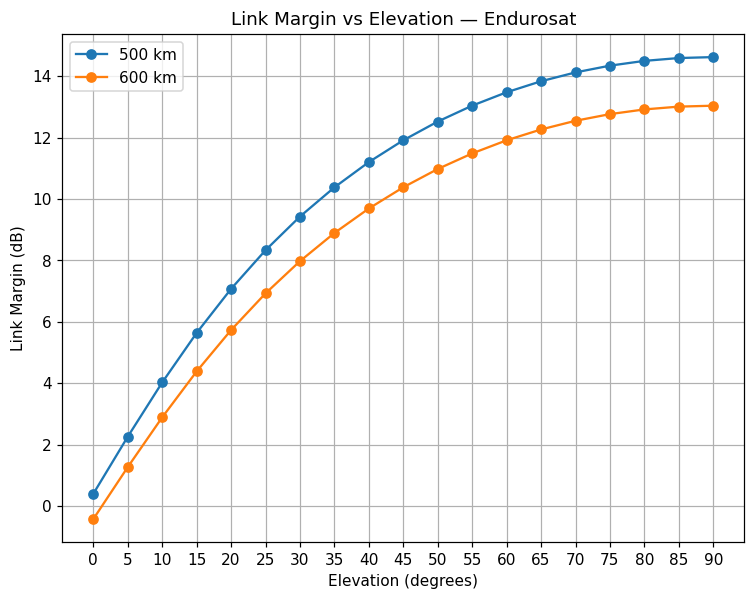

[info] Plot saved -> C:\GitHub\satellite-system-simulation\link_data_budget\x_band\Endurosat_link_margin_vs_elevation_step5.png


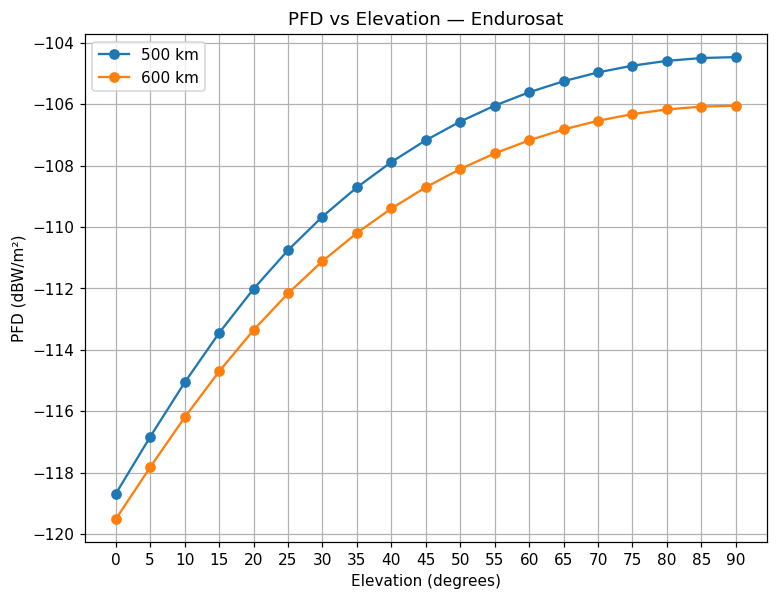

[info] Plot saved -> C:\GitHub\satellite-system-simulation\link_data_budget\x_band\Endurosat_pfd_vs_elevation_step5.png
[info] SAIT results saved -> C:\GitHub\satellite-system-simulation\link_data_budget\x_band\SAIT_link_PFD_vs_elevation_step5.csv


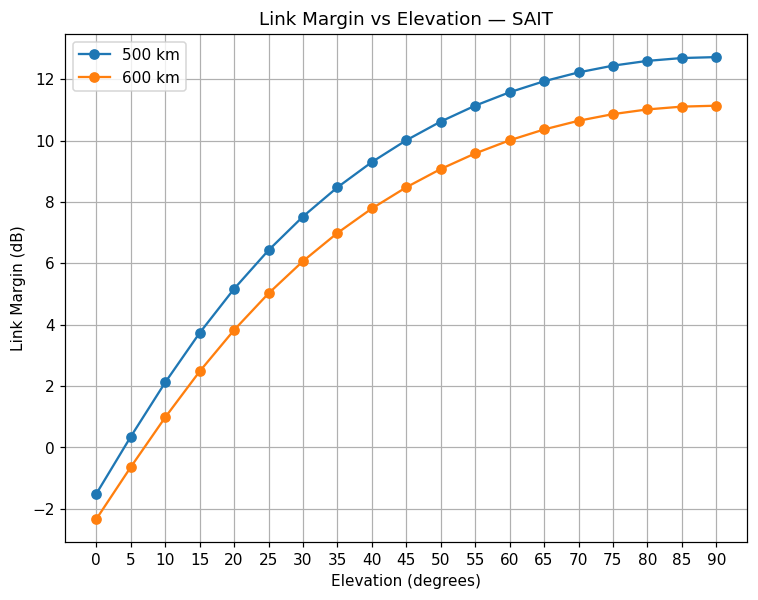

[info] Plot saved -> C:\GitHub\satellite-system-simulation\link_data_budget\x_band\SAIT_link_margin_vs_elevation_step5.png


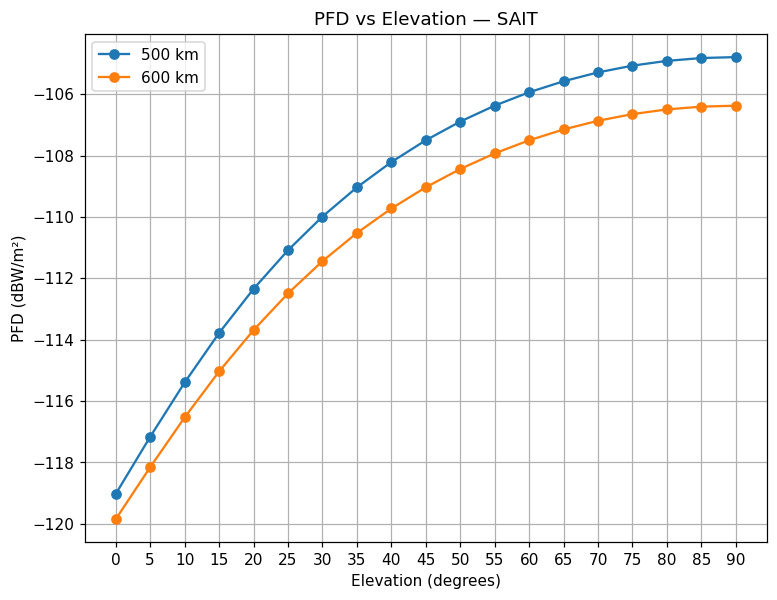

[info] Plot saved -> C:\GitHub\satellite-system-simulation\link_data_budget\x_band\SAIT_pfd_vs_elevation_step5.png


In [6]:
# %% [markdown]
# ## Run

# Locate CSV and read
csv_path = resolve_csv_path(CSV_CANDIDATES)
df = pd.read_csv(csv_path)

# Find the `python_variable` column robustly
pv_cols = [c for c in df.columns if c.strip().lower() == "python_variable"]
if not pv_cols:
    raise RuntimeError("Could not find a 'python_variable' column in the CSV.")
pv_col = pv_cols[0]

# Output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Save and show full parameter printout
params_out = OUTPUT_DIR / "parameters_printout.csv"
df.to_csv(params_out, index=False)
print(f"[info] Parameters printout saved -> {params_out.resolve()}")
display(df.head(20))

# Detect radios
radios = resolve_radio_columns(df, pv_col)
if not radios:
    raise RuntimeError("No radio columns detected. Ensure your CSV has radio columns (e.g., 'Endurosat', 'SAIT').")
print(f"[info] Radios detected -> {radios}")

# Build elevation grid
elevations = list(range(0, 91, ELEV_STEP_DEG))

# Compute
records = []
missing_report: Dict[str, List[str]] = {}

for radio in radios:
    # Required
    f_ghz = get_var(df, pv_col, "selected_carrier_frequency", radio, None)
    tx_power_w = get_var(df, pv_col, "tx_power", radio, None)
    Gtx_dbi = get_var(df, pv_col, "peak_boresight_antenna_gain", radio, None)
    G_T = get_var(df, pv_col, "g_t", radio, None)
    Rb_dBHz = get_var(df, pv_col, "data_rate_in_db_hz", radio, None)

    # Optional / losses
    Ltx_db = get_var_any(df, pv_col, ["interconnect_losses_gains", "interconnect_loss"], radio, 0.0)
    atm = get_var(df, pv_col, "atmospheric_attenuation", radio, 0.0)
    rain = get_var(df, pv_col, "rain_attenuation", radio, 0.0)
    scint = get_var(df, pv_col, "scintillation_loss", radio, 0.0)
    pol = get_var(df, pv_col, "polarisation_loss", radio, 0.0)
    other_prop = get_var(df, pv_col, "other_propagation_losses", radio, 0.0)
    EbN0_req = get_var(df, pv_col, "codmod_inferred_required_eb_n0", radio, 0.0)
    other_overall = get_var(df, pv_col, "other_overall_link_losses", radio, 0.0)
    rolloff = get_var(df, pv_col, "gain_rolloff_loss_at_pointing_error", radio, 0.0)

    missing = [n for n, v in {
        "selected_carrier_frequency": f_ghz,
        "tx_power": tx_power_w,
        "peak_boresight_antenna_gain": Gtx_dbi,
        "g_t": G_T,
        "data_rate_in_db_hz": Rb_dBHz,
    }.items() if v is None]
    if missing:
        missing_report[radio] = missing
        print(f"[warn] Skipping radio '{radio}' due to missing fields: {missing}")
        continue

    for alt in ALTITUDES_KM:
        for el in elevations:
            sr_km = slant_range_km(alt, el)
            Lfs = fspl_db(sr_km, f_ghz)
            Ltotal = Lfs + (atm or 0.0) + (rain or 0.0) + (scint or 0.0) + (pol or 0.0) + (other_prop or 0.0)
            eirp = eirp_dbw(tx_power_w, Gtx_dbi, Ltx_db or 0.0)
            cn0 = cn0_dbhz(eirp, Ltotal, G_T, 1.38e-23, (other_overall or 0.0) + (rolloff or 0.0))
            ebn0 = cn0 - Rb_dBHz
            margin = ebn0 - (EbN0_req or 0.0)
            pfd = pfd_dbw_per_m2(eirp, sr_km)

            records.append({
                "radio": radio,
                "orbit_altitude_km": alt,
                "elevation_deg": el,
                "slant_range_km": sr_km,
                "fspl_db": Lfs,
                "total_prop_loss_db": Ltotal,
                "eirp_dbw": eirp,
                "cn0_dbhz": cn0,
                "ebn0_db": ebn0,
                "link_margin_db": margin,
                "pfd_dbw_per_m2": pfd,
            })

if not records:
    raise RuntimeError("No results computed — were all radios missing required fields?")

df_out = pd.DataFrame(records)
combined_csv = OUTPUT_DIR / "all_radios_link_PFD_vs_elevation_step5.csv"
df_out.to_csv(combined_csv, index=False)
print(f"[info] Combined results saved -> {combined_csv.resolve()}")
display(df_out.head(24))

# Per-radio CSVs + plots
for radio in sorted(df_out['radio'].unique()):
    sub = df_out[df_out['radio'] == radio].copy()
    rname = sanitize_name(radio)

    # Save per-radio CSV
    per_csv = OUTPUT_DIR / f"{rname}_link_PFD_vs_elevation_step5.csv"
    sub.to_csv(per_csv, index=False)
    print(f"[info] {radio} results saved -> {per_csv.resolve()}")

    # Plot: Link Margin vs Elevation
    plt.figure()
    for alt in sorted(sub["orbit_altitude_km"].unique()):
        ss = sub[sub["orbit_altitude_km"] == alt].sort_values("elevation_deg")
        plt.plot(ss["elevation_deg"], ss["link_margin_db"], marker="o", label=f"{int(alt)} km")
    plt.title(f"Link Margin vs Elevation — {radio}")
    plt.xlabel("Elevation (degrees)")
    plt.ylabel("Link Margin (dB)")
    plt.xticks(list(range(0, 91, ELEV_STEP_DEG)))
    plt.grid(True)
    plt.legend()
    lm_png = OUTPUT_DIR / f"{rname}_link_margin_vs_elevation_step5.png"
    plt.savefig(lm_png, bbox_inches="tight")
    plt.show()
    print(f"[info] Plot saved -> {lm_png.resolve()}")

    # Plot: PFD vs Elevation
    plt.figure()
    for alt in sorted(sub["orbit_altitude_km"].unique()):
        ss = sub[sub["orbit_altitude_km"] == alt].sort_values("elevation_deg")
        plt.plot(ss["elevation_deg"], ss["pfd_dbw_per_m2"], marker="o", label=f"{int(alt)} km")
    plt.title(f"PFD vs Elevation — {radio}")
    plt.xlabel("Elevation (degrees)")
    plt.ylabel("PFD (dBW/m²)")
    plt.xticks(list(range(0, 91, ELEV_STEP_DEG)))
    plt.grid(True)
    plt.legend()
    pfd_png = OUTPUT_DIR / f"{rname}_pfd_vs_elevation_step5.png"
    plt.savefig(pfd_png, bbox_inches="tight")
    plt.show()
    print(f"[info] Plot saved -> {pfd_png.resolve()}")

if missing_report:
    print("\n[summary] Radios skipped due to missing required fields:")
    for r, miss in missing_report.items():
        print(f"  - {r}: missing {miss}")